In [18]:
import numpy as np
import pandas as pd
import os, pickle, sys
from scipy import signal
import arr

### input 설정
SRATE = 250 # 250Hz
LEN_INPUT = 20 # input 10s
LEN_PER_NRS = 60 # vital length for each NRS
OVERLAP = 2
n_aug = int((LEN_PER_NRS-LEN_INPUT)/OVERLAP) + 1 # data augmentation 개수




input_path = 'dataset/preprocess2/input3-2/'
if not os.path.exists(input_path[:-1]):
    os.mkdir(input_path[:-1])

if not os.path.exists(input_path+'x_train_pacu.npz'):
    print('loading train...', flush=True, end='')
    x_train_pacu = np.load(input_path+'x_train_pacu.npz', allow_pickle=True)['arr_0']
    y_train_pacu = np.load(input_path+'y_train_pacu.npz')['arr_0']
    x_test_pacu = np.load(input_path+'x_test_pacu.npz', allow_pickle=True)['arr_0']
    y_test_pacu = np.load(input_path+'y_test_pacu.npz')['arr_0']
    print('done', flush=True)

else:
    false_row_list_preop = []
    
    vital_path = '../../cranberry2/Preprocessing/NRS_vital_pickle_unzip/NRS_vital_pickle'
    ecg_path = '../../cranberry2/Preprocessing/ECG_250Hz/ECG_250Hz/ECG,'
    df_preprocess_pacu = pickle.load(open('cache/preprocess2/input3/df_preprocess_pacu','rb'))
    

    ### test set에 해당하는 file_path
    caseid_test = pickle.load(open('caseid_test', 'rb'))
    caseid_train = pickle.load(open('caseid_train', 'rb'))
    caseid_val = pickle.load(open('caseid_val', 'rb'))
    

    x_train_pacu, y_train_pacu = [], []
    x_test_pacu, y_test_pacu = [], []
    x_val_pacu, y_val_pacu = [], []

    cnt = 0
    for _, row in df_preprocess_pacu.iterrows():
        cnt += 1
        print('loading data {}/{} ...'.format(cnt, len(df_preprocess_pacu)), end='')

        # vital data - PPG (resampling 100 Hz to 250 Hz)
        df_vital = pickle.load(open(vital_path+'/'+row['file_path'], 'rb')).reset_index()
        pleth_samp = df_vital[['Pleth']].fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
        pleth_resamp = signal.resample(pleth_samp, 120*SRATE)
        ppg_per_NRS = np.full(30000, np.nan)
        ppg_per_NRS[0:len(pleth_resamp)] = pleth_resamp
        

        # vital data - ECG (250Hz)
        ecg_samp = pickle.load(open(ecg_path+row['file_path'][:-3]+'vital', 'rb')).reset_index()[['ECG']]
        ecg_samp = ecg_samp.fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()[0:30000]
        ecg_per_NRS = np.full(30000,np.nan)
        ecg_per_NRS[0:len(ecg_samp)] = ecg_samp
   

        # 한 NRS에 대해 23개의 input 확인
        for i in range(30,51):
            # input이 전처리 통과한 경우
            if row[str(i+1)][0]:
                start_idx = i*OVERLAP*SRATE # 500i
                end_idx = (i*OVERLAP+LEN_INPUT)*SRATE # 500i + 1000
                
                # input의 normalization
                data = ppg_per_NRS[start_idx:end_idx]
                fdata =  arr.low_pass(data, 250,100)
                pleth_inp = fdata.reshape(5000,1)
                pleth_inp = pleth_inp - np.nanmean(pleth_inp)

                data = ecg_per_NRS[start_idx:end_idx]
                fdata =  arr.low_pass(data, 250,100)
                ecg_inp = fdata.reshape(5000,1)
                ecg_inp = (ecg_inp - np.nanmean(ecg_inp)) / np.nanstd(ecg_inp)
                
                if np.sum(np.isnan(pleth_inp)) != 0:
                    continue
                
                if np.sum(np.isnan(ecg_inp)) != 0:
                    continue
                    
                # 해당 caseid가 test set에 속하는 경우
                if row['caseids'] in caseid_test:
                    x_test_pacu.append([pleth_inp, ecg_inp])
                    y_test_pacu.append(int(float(row['NRS'])))

                # 해당 caseid가 train set에 해당하는 경우
                elif row['caseids'] in caseid_val:
                    x_val_pacu.append([pleth_inp, ecg_inp])
                    y_val_pacu.append(int(float(row['NRS'])))
                    
                else:
                    x_train_pacu.append([pleth_inp, ecg_inp])
                    y_train_pacu.append(int(float(row['NRS'])))
                    
        print('completed')

    x_train_pacu = np.array(x_train_pacu, np.float32)
    x_test_pacu = np.array(x_test_pacu, np.float32)
    y_train_pacu = np.array(y_train_pacu, int)
    y_test_pacu = np.array(y_test_pacu, int)
    x_val_pacu = np.array(x_val_pacu, np.float32)
    y_val_pacu = np.array(y_val_pacu, int)
    
    
print('size of training set(pacu):', len(x_train_pacu))
print('size of validation set(pacu):', len(x_val_pacu))
print('size of test set(pacu):', len(x_test_pacu))

loading data 1/7316 ...completed
loading data 2/7316 ...completed
loading data 3/7316 ...completed
loading data 4/7316 ...completed
loading data 5/7316 ...completed
loading data 6/7316 ...completed
loading data 7/7316 ...completed
loading data 8/7316 ...completed
loading data 9/7316 ...completed
loading data 10/7316 ...completed
loading data 11/7316 ...completed
loading data 12/7316 ...completed
loading data 13/7316 ...completed
loading data 14/7316 ...completed
loading data 15/7316 ...completed
loading data 16/7316 ...completed
loading data 17/7316 ...completed
loading data 18/7316 ...completed
loading data 19/7316 ...completed
loading data 20/7316 ...completed
loading data 21/7316 ...completed
loading data 22/7316 ...completed
loading data 23/7316 ...completed
loading data 24/7316 ...completed
loading data 25/7316 ...completed
loading data 26/7316 ...completed
loading data 27/7316 ...completed
loading data 28/7316 ...completed
loading data 29/7316 ...completed
loading data 30/7316 ..

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:83: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.6/dist-packages/numpy/lib/nanfunctions.py:1666: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


completed
loading data 74/7316 ...completed
loading data 75/7316 ...completed
loading data 76/7316 ...completed
loading data 77/7316 ...completed
loading data 78/7316 ...completed
loading data 79/7316 ...completed
loading data 80/7316 ...completed
loading data 81/7316 ...completed
loading data 82/7316 ...completed
loading data 83/7316 ...completed
loading data 84/7316 ...completed
loading data 85/7316 ...completed
loading data 86/7316 ...completed
loading data 87/7316 ...completed
loading data 88/7316 ...completed
loading data 89/7316 ...completed
loading data 90/7316 ...completed
loading data 91/7316 ...completed
loading data 92/7316 ...completed
loading data 93/7316 ...completed
loading data 94/7316 ...completed
loading data 95/7316 ...completed
loading data 96/7316 ...completed
loading data 97/7316 ...completed
loading data 98/7316 ...completed
loading data 99/7316 ...completed
loading data 100/7316 ...completed
loading data 101/7316 ...completed
loading data 102/7316 ...completed
l

loading data 308/7316 ...completed
loading data 309/7316 ...completed
loading data 310/7316 ...completed
loading data 311/7316 ...completed
loading data 312/7316 ...completed
loading data 313/7316 ...completed
loading data 314/7316 ...completed
loading data 315/7316 ...completed
loading data 316/7316 ...completed
loading data 317/7316 ...completed
loading data 318/7316 ...completed
loading data 319/7316 ...completed
loading data 320/7316 ...completed
loading data 321/7316 ...completed
loading data 322/7316 ...completed
loading data 323/7316 ...completed
loading data 324/7316 ...completed
loading data 325/7316 ...completed
loading data 326/7316 ...completed
loading data 327/7316 ...completed
loading data 328/7316 ...completed
loading data 329/7316 ...completed
loading data 330/7316 ...completed
loading data 331/7316 ...completed
loading data 332/7316 ...completed
loading data 333/7316 ...completed
loading data 334/7316 ...completed
loading data 335/7316 ...completed
loading data 336/731

loading data 544/7316 ...completed
loading data 545/7316 ...completed
loading data 546/7316 ...completed
loading data 547/7316 ...completed
loading data 548/7316 ...completed
loading data 549/7316 ...completed
loading data 550/7316 ...completed
loading data 551/7316 ...completed
loading data 552/7316 ...completed
loading data 553/7316 ...completed
loading data 554/7316 ...completed
loading data 555/7316 ...completed
loading data 556/7316 ...completed
loading data 557/7316 ...completed
loading data 558/7316 ...completed
loading data 559/7316 ...completed
loading data 560/7316 ...completed
loading data 561/7316 ...completed
loading data 562/7316 ...completed
loading data 563/7316 ...completed
loading data 564/7316 ...completed
loading data 565/7316 ...completed
loading data 566/7316 ...completed
loading data 567/7316 ...completed
loading data 568/7316 ...completed
loading data 569/7316 ...completed
loading data 570/7316 ...completed
loading data 571/7316 ...completed
loading data 572/731

loading data 778/7316 ...completed
loading data 779/7316 ...completed
loading data 780/7316 ...completed
loading data 781/7316 ...completed
loading data 782/7316 ...completed
loading data 783/7316 ...completed
loading data 784/7316 ...completed
loading data 785/7316 ...completed
loading data 786/7316 ...completed
loading data 787/7316 ...completed
loading data 788/7316 ...completed
loading data 789/7316 ...completed
loading data 790/7316 ...completed
loading data 791/7316 ...completed
loading data 792/7316 ...completed
loading data 793/7316 ...completed
loading data 794/7316 ...completed
loading data 795/7316 ...completed
loading data 796/7316 ...completed
loading data 797/7316 ...completed
loading data 798/7316 ...completed
loading data 799/7316 ...completed
loading data 800/7316 ...completed
loading data 801/7316 ...completed
loading data 802/7316 ...completed
loading data 803/7316 ...completed
loading data 804/7316 ...completed
loading data 805/7316 ...completed
loading data 806/731

loading data 1013/7316 ...completed
loading data 1014/7316 ...completed
loading data 1015/7316 ...completed
loading data 1016/7316 ...completed
loading data 1017/7316 ...completed
loading data 1018/7316 ...completed
loading data 1019/7316 ...completed
loading data 1020/7316 ...completed
loading data 1021/7316 ...completed
loading data 1022/7316 ...completed
loading data 1023/7316 ...completed
loading data 1024/7316 ...completed
loading data 1025/7316 ...completed
loading data 1026/7316 ...completed
loading data 1027/7316 ...completed
loading data 1028/7316 ...completed
loading data 1029/7316 ...completed
loading data 1030/7316 ...completed
loading data 1031/7316 ...completed
loading data 1032/7316 ...completed
loading data 1033/7316 ...completed
loading data 1034/7316 ...completed
loading data 1035/7316 ...completed
loading data 1036/7316 ...completed
loading data 1037/7316 ...completed
loading data 1038/7316 ...completed
loading data 1039/7316 ...completed
loading data 1040/7316 ...co

loading data 1240/7316 ...completed
loading data 1241/7316 ...completed
loading data 1242/7316 ...completed
loading data 1243/7316 ...completed
loading data 1244/7316 ...completed
loading data 1245/7316 ...completed
loading data 1246/7316 ...completed
loading data 1247/7316 ...completed
loading data 1248/7316 ...completed
loading data 1249/7316 ...completed
loading data 1250/7316 ...completed
loading data 1251/7316 ...completed
loading data 1252/7316 ...completed
loading data 1253/7316 ...completed
loading data 1254/7316 ...completed
loading data 1255/7316 ...completed
loading data 1256/7316 ...completed
loading data 1257/7316 ...completed
loading data 1258/7316 ...completed
loading data 1259/7316 ...completed
loading data 1260/7316 ...completed
loading data 1261/7316 ...completed
loading data 1262/7316 ...completed
loading data 1263/7316 ...completed
loading data 1264/7316 ...completed
loading data 1265/7316 ...completed
loading data 1266/7316 ...completed
loading data 1267/7316 ...co

loading data 1468/7316 ...completed
loading data 1469/7316 ...completed
loading data 1470/7316 ...completed
loading data 1471/7316 ...completed
loading data 1472/7316 ...completed
loading data 1473/7316 ...completed
loading data 1474/7316 ...completed
loading data 1475/7316 ...completed
loading data 1476/7316 ...completed
loading data 1477/7316 ...completed
loading data 1478/7316 ...completed
loading data 1479/7316 ...completed
loading data 1480/7316 ...completed
loading data 1481/7316 ...completed
loading data 1482/7316 ...completed
loading data 1483/7316 ...completed
loading data 1484/7316 ...completed
loading data 1485/7316 ...completed
loading data 1486/7316 ...completed
loading data 1487/7316 ...completed
loading data 1488/7316 ...completed
loading data 1489/7316 ...completed
loading data 1490/7316 ...completed
loading data 1491/7316 ...completed
loading data 1492/7316 ...completed
loading data 1493/7316 ...completed
loading data 1494/7316 ...completed
loading data 1495/7316 ...co

loading data 1696/7316 ...completed
loading data 1697/7316 ...completed
loading data 1698/7316 ...completed
loading data 1699/7316 ...completed
loading data 1700/7316 ...completed
loading data 1701/7316 ...completed
loading data 1702/7316 ...completed
loading data 1703/7316 ...completed
loading data 1704/7316 ...completed
loading data 1705/7316 ...completed
loading data 1706/7316 ...completed
loading data 1707/7316 ...completed
loading data 1708/7316 ...completed
loading data 1709/7316 ...completed
loading data 1710/7316 ...completed
loading data 1711/7316 ...completed
loading data 1712/7316 ...completed
loading data 1713/7316 ...completed
loading data 1714/7316 ...completed
loading data 1715/7316 ...completed
loading data 1716/7316 ...completed
loading data 1717/7316 ...completed
loading data 1718/7316 ...completed
loading data 1719/7316 ...completed
loading data 1720/7316 ...completed
loading data 1721/7316 ...completed
loading data 1722/7316 ...completed
loading data 1723/7316 ...co

loading data 1926/7316 ...completed
loading data 1927/7316 ...completed
loading data 1928/7316 ...completed
loading data 1929/7316 ...completed
loading data 1930/7316 ...completed
loading data 1931/7316 ...completed
loading data 1932/7316 ...completed
loading data 1933/7316 ...completed
loading data 1934/7316 ...completed
loading data 1935/7316 ...completed
loading data 1936/7316 ...completed
loading data 1937/7316 ...completed
loading data 1938/7316 ...completed
loading data 1939/7316 ...completed
loading data 1940/7316 ...completed
loading data 1941/7316 ...completed
loading data 1942/7316 ...completed
loading data 1943/7316 ...completed
loading data 1944/7316 ...completed
loading data 1945/7316 ...completed
loading data 1946/7316 ...completed
loading data 1947/7316 ...completed
loading data 1948/7316 ...completed
loading data 1949/7316 ...completed
loading data 1950/7316 ...completed
loading data 1951/7316 ...completed
loading data 1952/7316 ...completed
loading data 1953/7316 ...co

loading data 2153/7316 ...completed
loading data 2154/7316 ...completed
loading data 2155/7316 ...completed
loading data 2156/7316 ...completed
loading data 2157/7316 ...completed
loading data 2158/7316 ...completed
loading data 2159/7316 ...completed
loading data 2160/7316 ...completed
loading data 2161/7316 ...completed
loading data 2162/7316 ...completed
loading data 2163/7316 ...completed
loading data 2164/7316 ...completed
loading data 2165/7316 ...completed
loading data 2166/7316 ...completed
loading data 2167/7316 ...completed
loading data 2168/7316 ...completed
loading data 2169/7316 ...completed
loading data 2170/7316 ...completed
loading data 2171/7316 ...completed
loading data 2172/7316 ...completed
loading data 2173/7316 ...completed
loading data 2174/7316 ...completed
loading data 2175/7316 ...completed
loading data 2176/7316 ...completed
loading data 2177/7316 ...completed
loading data 2178/7316 ...completed
loading data 2179/7316 ...completed
loading data 2180/7316 ...co

loading data 2380/7316 ...completed
loading data 2381/7316 ...completed
loading data 2382/7316 ...completed
loading data 2383/7316 ...completed
loading data 2384/7316 ...completed
loading data 2385/7316 ...completed
loading data 2386/7316 ...completed
loading data 2387/7316 ...completed
loading data 2388/7316 ...completed
loading data 2389/7316 ...completed
loading data 2390/7316 ...completed
loading data 2391/7316 ...completed
loading data 2392/7316 ...completed
loading data 2393/7316 ...completed
loading data 2394/7316 ...completed
loading data 2395/7316 ...completed
loading data 2396/7316 ...completed
loading data 2397/7316 ...completed
loading data 2398/7316 ...completed
loading data 2399/7316 ...completed
loading data 2400/7316 ...completed
loading data 2401/7316 ...completed
loading data 2402/7316 ...completed
loading data 2403/7316 ...completed
loading data 2404/7316 ...completed
loading data 2405/7316 ...completed
loading data 2406/7316 ...completed
loading data 2407/7316 ...co

loading data 2609/7316 ...completed
loading data 2610/7316 ...completed
loading data 2611/7316 ...completed
loading data 2612/7316 ...completed
loading data 2613/7316 ...completed
loading data 2614/7316 ...completed
loading data 2615/7316 ...completed
loading data 2616/7316 ...completed
loading data 2617/7316 ...completed
loading data 2618/7316 ...completed
loading data 2619/7316 ...completed
loading data 2620/7316 ...completed
loading data 2621/7316 ...completed
loading data 2622/7316 ...completed
loading data 2623/7316 ...completed
loading data 2624/7316 ...completed
loading data 2625/7316 ...completed
loading data 2626/7316 ...completed
loading data 2627/7316 ...completed
loading data 2628/7316 ...completed
loading data 2629/7316 ...completed
loading data 2630/7316 ...completed
loading data 2631/7316 ...completed
loading data 2632/7316 ...completed
loading data 2633/7316 ...completed
loading data 2634/7316 ...completed
loading data 2635/7316 ...completed
loading data 2636/7316 ...co

loading data 2837/7316 ...completed
loading data 2838/7316 ...completed
loading data 2839/7316 ...completed
loading data 2840/7316 ...completed
loading data 2841/7316 ...completed
loading data 2842/7316 ...completed
loading data 2843/7316 ...completed
loading data 2844/7316 ...completed
loading data 2845/7316 ...completed
loading data 2846/7316 ...completed
loading data 2847/7316 ...completed
loading data 2848/7316 ...completed
loading data 2849/7316 ...completed
loading data 2850/7316 ...completed
loading data 2851/7316 ...completed
loading data 2852/7316 ...completed
loading data 2853/7316 ...completed
loading data 2854/7316 ...completed
loading data 2855/7316 ...completed
loading data 2856/7316 ...completed
loading data 2857/7316 ...completed
loading data 2858/7316 ...completed
loading data 2859/7316 ...completed
loading data 2860/7316 ...completed
loading data 2861/7316 ...completed
loading data 2862/7316 ...completed
loading data 2863/7316 ...completed
loading data 2864/7316 ...co

loading data 3066/7316 ...completed
loading data 3067/7316 ...completed
loading data 3068/7316 ...completed
loading data 3069/7316 ...completed
loading data 3070/7316 ...completed
loading data 3071/7316 ...completed
loading data 3072/7316 ...completed
loading data 3073/7316 ...completed
loading data 3074/7316 ...completed
loading data 3075/7316 ...completed
loading data 3076/7316 ...completed
loading data 3077/7316 ...completed
loading data 3078/7316 ...completed
loading data 3079/7316 ...completed
loading data 3080/7316 ...completed
loading data 3081/7316 ...completed
loading data 3082/7316 ...completed
loading data 3083/7316 ...completed
loading data 3084/7316 ...completed
loading data 3085/7316 ...completed
loading data 3086/7316 ...completed
loading data 3087/7316 ...completed
loading data 3088/7316 ...completed
loading data 3089/7316 ...completed
loading data 3090/7316 ...completed
loading data 3091/7316 ...completed
loading data 3092/7316 ...completed
loading data 3093/7316 ...co

loading data 3293/7316 ...completed
loading data 3294/7316 ...completed
loading data 3295/7316 ...completed
loading data 3296/7316 ...completed
loading data 3297/7316 ...completed
loading data 3298/7316 ...completed
loading data 3299/7316 ...completed
loading data 3300/7316 ...completed
loading data 3301/7316 ...completed
loading data 3302/7316 ...completed
loading data 3303/7316 ...completed
loading data 3304/7316 ...completed
loading data 3305/7316 ...completed
loading data 3306/7316 ...completed
loading data 3307/7316 ...completed
loading data 3308/7316 ...completed
loading data 3309/7316 ...completed
loading data 3310/7316 ...completed
loading data 3311/7316 ...completed
loading data 3312/7316 ...completed
loading data 3313/7316 ...completed
loading data 3314/7316 ...completed
loading data 3315/7316 ...completed
loading data 3316/7316 ...completed
loading data 3317/7316 ...completed
loading data 3318/7316 ...completed
loading data 3319/7316 ...completed
loading data 3320/7316 ...co

loading data 3521/7316 ...completed
loading data 3522/7316 ...completed
loading data 3523/7316 ...completed
loading data 3524/7316 ...completed
loading data 3525/7316 ...completed
loading data 3526/7316 ...completed
loading data 3527/7316 ...completed
loading data 3528/7316 ...completed
loading data 3529/7316 ...completed
loading data 3530/7316 ...completed
loading data 3531/7316 ...completed
loading data 3532/7316 ...completed
loading data 3533/7316 ...completed
loading data 3534/7316 ...completed
loading data 3535/7316 ...completed
loading data 3536/7316 ...completed
loading data 3537/7316 ...completed
loading data 3538/7316 ...completed
loading data 3539/7316 ...completed
loading data 3540/7316 ...completed
loading data 3541/7316 ...completed
loading data 3542/7316 ...completed
loading data 3543/7316 ...completed
loading data 3544/7316 ...completed
loading data 3545/7316 ...completed
loading data 3546/7316 ...completed
loading data 3547/7316 ...completed
loading data 3548/7316 ...co

loading data 3749/7316 ...completed
loading data 3750/7316 ...completed
loading data 3751/7316 ...completed
loading data 3752/7316 ...completed
loading data 3753/7316 ...completed
loading data 3754/7316 ...completed
loading data 3755/7316 ...completed
loading data 3756/7316 ...completed
loading data 3757/7316 ...completed
loading data 3758/7316 ...completed
loading data 3759/7316 ...completed
loading data 3760/7316 ...completed
loading data 3761/7316 ...completed
loading data 3762/7316 ...completed
loading data 3763/7316 ...completed
loading data 3764/7316 ...completed
loading data 3765/7316 ...completed
loading data 3766/7316 ...completed
loading data 3767/7316 ...completed
loading data 3768/7316 ...completed
loading data 3769/7316 ...completed
loading data 3770/7316 ...completed
loading data 3771/7316 ...completed
loading data 3772/7316 ...completed
loading data 3773/7316 ...completed
loading data 3774/7316 ...completed
loading data 3775/7316 ...completed
loading data 3776/7316 ...co

loading data 3978/7316 ...completed
loading data 3979/7316 ...completed
loading data 3980/7316 ...completed
loading data 3981/7316 ...completed
loading data 3982/7316 ...completed
loading data 3983/7316 ...completed
loading data 3984/7316 ...completed
loading data 3985/7316 ...completed
loading data 3986/7316 ...completed
loading data 3987/7316 ...completed
loading data 3988/7316 ...completed
loading data 3989/7316 ...completed
loading data 3990/7316 ...completed
loading data 3991/7316 ...completed
loading data 3992/7316 ...completed
loading data 3993/7316 ...completed
loading data 3994/7316 ...completed
loading data 3995/7316 ...completed
loading data 3996/7316 ...completed
loading data 3997/7316 ...completed
loading data 3998/7316 ...completed
loading data 3999/7316 ...completed
loading data 4000/7316 ...completed
loading data 4001/7316 ...completed
loading data 4002/7316 ...completed
loading data 4003/7316 ...completed
loading data 4004/7316 ...completed
loading data 4005/7316 ...co

loading data 4207/7316 ...completed
loading data 4208/7316 ...completed
loading data 4209/7316 ...completed
loading data 4210/7316 ...completed
loading data 4211/7316 ...completed
loading data 4212/7316 ...completed
loading data 4213/7316 ...completed
loading data 4214/7316 ...completed
loading data 4215/7316 ...completed
loading data 4216/7316 ...completed
loading data 4217/7316 ...completed
loading data 4218/7316 ...completed
loading data 4219/7316 ...completed
loading data 4220/7316 ...completed
loading data 4221/7316 ...completed
loading data 4222/7316 ...completed
loading data 4223/7316 ...completed
loading data 4224/7316 ...completed
loading data 4225/7316 ...completed
loading data 4226/7316 ...completed
loading data 4227/7316 ...completed
loading data 4228/7316 ...completed
loading data 4229/7316 ...completed
loading data 4230/7316 ...completed
loading data 4231/7316 ...completed
loading data 4232/7316 ...completed
loading data 4233/7316 ...completed
loading data 4234/7316 ...co

loading data 4435/7316 ...completed
loading data 4436/7316 ...completed
loading data 4437/7316 ...completed
loading data 4438/7316 ...completed
loading data 4439/7316 ...completed
loading data 4440/7316 ...completed
loading data 4441/7316 ...completed
loading data 4442/7316 ...completed
loading data 4443/7316 ...completed
loading data 4444/7316 ...completed
loading data 4445/7316 ...completed
loading data 4446/7316 ...completed
loading data 4447/7316 ...completed
loading data 4448/7316 ...completed
loading data 4449/7316 ...completed
loading data 4450/7316 ...completed
loading data 4451/7316 ...completed
loading data 4452/7316 ...completed
loading data 4453/7316 ...completed
loading data 4454/7316 ...completed
loading data 4455/7316 ...completed
loading data 4456/7316 ...completed
loading data 4457/7316 ...completed
loading data 4458/7316 ...completed
loading data 4459/7316 ...completed
loading data 4460/7316 ...completed
loading data 4461/7316 ...completed
loading data 4462/7316 ...co

loading data 4664/7316 ...completed
loading data 4665/7316 ...completed
loading data 4666/7316 ...completed
loading data 4667/7316 ...completed
loading data 4668/7316 ...completed
loading data 4669/7316 ...completed
loading data 4670/7316 ...completed
loading data 4671/7316 ...completed
loading data 4672/7316 ...completed
loading data 4673/7316 ...completed
loading data 4674/7316 ...completed
loading data 4675/7316 ...completed
loading data 4676/7316 ...completed
loading data 4677/7316 ...completed
loading data 4678/7316 ...completed
loading data 4679/7316 ...completed
loading data 4680/7316 ...completed
loading data 4681/7316 ...completed
loading data 4682/7316 ...completed
loading data 4683/7316 ...completed
loading data 4684/7316 ...completed
loading data 4685/7316 ...completed
loading data 4686/7316 ...completed
loading data 4687/7316 ...completed
loading data 4688/7316 ...completed
loading data 4689/7316 ...completed
loading data 4690/7316 ...completed
loading data 4691/7316 ...co

loading data 4891/7316 ...completed
loading data 4892/7316 ...completed
loading data 4893/7316 ...completed
loading data 4894/7316 ...completed
loading data 4895/7316 ...completed
loading data 4896/7316 ...completed
loading data 4897/7316 ...completed
loading data 4898/7316 ...completed
loading data 4899/7316 ...completed
loading data 4900/7316 ...completed
loading data 4901/7316 ...completed
loading data 4902/7316 ...completed
loading data 4903/7316 ...completed
loading data 4904/7316 ...completed
loading data 4905/7316 ...completed
loading data 4906/7316 ...completed
loading data 4907/7316 ...completed
loading data 4908/7316 ...completed
loading data 4909/7316 ...completed
loading data 4910/7316 ...completed
loading data 4911/7316 ...completed
loading data 4912/7316 ...completed
loading data 4913/7316 ...completed
loading data 4914/7316 ...completed
loading data 4915/7316 ...completed
loading data 4916/7316 ...completed
loading data 4917/7316 ...completed
loading data 4918/7316 ...co

loading data 5118/7316 ...completed
loading data 5119/7316 ...completed
loading data 5120/7316 ...completed
loading data 5121/7316 ...completed
loading data 5122/7316 ...completed
loading data 5123/7316 ...completed
loading data 5124/7316 ...completed
loading data 5125/7316 ...completed
loading data 5126/7316 ...completed
loading data 5127/7316 ...completed
loading data 5128/7316 ...completed
loading data 5129/7316 ...completed
loading data 5130/7316 ...completed
loading data 5131/7316 ...completed
loading data 5132/7316 ...completed
loading data 5133/7316 ...completed
loading data 5134/7316 ...completed
loading data 5135/7316 ...completed
loading data 5136/7316 ...completed
loading data 5137/7316 ...completed
loading data 5138/7316 ...completed
loading data 5139/7316 ...completed
loading data 5140/7316 ...completed
loading data 5141/7316 ...completed
loading data 5142/7316 ...completed
loading data 5143/7316 ...completed
loading data 5144/7316 ...completed
loading data 5145/7316 ...co

loading data 5346/7316 ...completed
loading data 5347/7316 ...completed
loading data 5348/7316 ...completed
loading data 5349/7316 ...completed
loading data 5350/7316 ...completed
loading data 5351/7316 ...completed
loading data 5352/7316 ...completed
loading data 5353/7316 ...completed
loading data 5354/7316 ...completed
loading data 5355/7316 ...completed
loading data 5356/7316 ...completed
loading data 5357/7316 ...completed
loading data 5358/7316 ...completed
loading data 5359/7316 ...completed
loading data 5360/7316 ...completed
loading data 5361/7316 ...completed
loading data 5362/7316 ...completed
loading data 5363/7316 ...completed
loading data 5364/7316 ...completed
loading data 5365/7316 ...completed
loading data 5366/7316 ...completed
loading data 5367/7316 ...completed
loading data 5368/7316 ...completed
loading data 5369/7316 ...completed
loading data 5370/7316 ...completed
loading data 5371/7316 ...completed
loading data 5372/7316 ...completed
loading data 5373/7316 ...co

loading data 5574/7316 ...completed
loading data 5575/7316 ...completed
loading data 5576/7316 ...completed
loading data 5577/7316 ...completed
loading data 5578/7316 ...completed
loading data 5579/7316 ...completed
loading data 5580/7316 ...completed
loading data 5581/7316 ...completed
loading data 5582/7316 ...completed
loading data 5583/7316 ...completed
loading data 5584/7316 ...completed
loading data 5585/7316 ...completed
loading data 5586/7316 ...completed
loading data 5587/7316 ...completed
loading data 5588/7316 ...completed
loading data 5589/7316 ...completed
loading data 5590/7316 ...completed
loading data 5591/7316 ...completed
loading data 5592/7316 ...completed
loading data 5593/7316 ...completed
loading data 5594/7316 ...completed
loading data 5595/7316 ...completed
loading data 5596/7316 ...completed
loading data 5597/7316 ...completed
loading data 5598/7316 ...completed
loading data 5599/7316 ...completed
loading data 5600/7316 ...completed
loading data 5601/7316 ...co

loading data 5802/7316 ...completed
loading data 5803/7316 ...completed
loading data 5804/7316 ...completed
loading data 5805/7316 ...completed
loading data 5806/7316 ...completed
loading data 5807/7316 ...completed
loading data 5808/7316 ...completed
loading data 5809/7316 ...completed
loading data 5810/7316 ...completed
loading data 5811/7316 ...completed
loading data 5812/7316 ...completed
loading data 5813/7316 ...completed
loading data 5814/7316 ...completed
loading data 5815/7316 ...completed
loading data 5816/7316 ...completed
loading data 5817/7316 ...completed
loading data 5818/7316 ...completed
loading data 5819/7316 ...completed
loading data 5820/7316 ...completed
loading data 5821/7316 ...completed
loading data 5822/7316 ...completed
loading data 5823/7316 ...completed
loading data 5824/7316 ...completed
loading data 5825/7316 ...completed
loading data 5826/7316 ...completed
loading data 5827/7316 ...completed
loading data 5828/7316 ...completed
loading data 5829/7316 ...co

loading data 6031/7316 ...completed
loading data 6032/7316 ...completed
loading data 6033/7316 ...completed
loading data 6034/7316 ...completed
loading data 6035/7316 ...completed
loading data 6036/7316 ...completed
loading data 6037/7316 ...completed
loading data 6038/7316 ...completed
loading data 6039/7316 ...completed
loading data 6040/7316 ...completed
loading data 6041/7316 ...completed
loading data 6042/7316 ...completed
loading data 6043/7316 ...completed
loading data 6044/7316 ...completed
loading data 6045/7316 ...completed
loading data 6046/7316 ...completed
loading data 6047/7316 ...completed
loading data 6048/7316 ...completed
loading data 6049/7316 ...completed
loading data 6050/7316 ...completed
loading data 6051/7316 ...completed
loading data 6052/7316 ...completed
loading data 6053/7316 ...completed
loading data 6054/7316 ...completed
loading data 6055/7316 ...completed
loading data 6056/7316 ...completed
loading data 6057/7316 ...completed
loading data 6058/7316 ...co

loading data 6263/7316 ...completed
loading data 6264/7316 ...completed
loading data 6265/7316 ...completed
loading data 6266/7316 ...completed
loading data 6267/7316 ...completed
loading data 6268/7316 ...completed
loading data 6269/7316 ...completed
loading data 6270/7316 ...completed
loading data 6271/7316 ...completed
loading data 6272/7316 ...completed
loading data 6273/7316 ...completed
loading data 6274/7316 ...completed
loading data 6275/7316 ...completed
loading data 6276/7316 ...completed
loading data 6277/7316 ...completed
loading data 6278/7316 ...completed
loading data 6279/7316 ...completed
loading data 6280/7316 ...completed
loading data 6281/7316 ...completed
loading data 6282/7316 ...completed
loading data 6283/7316 ...completed
loading data 6284/7316 ...completed
loading data 6285/7316 ...completed
loading data 6286/7316 ...completed
loading data 6287/7316 ...completed
loading data 6288/7316 ...completed
loading data 6289/7316 ...completed
loading data 6290/7316 ...co

loading data 6494/7316 ...completed
loading data 6495/7316 ...completed
loading data 6496/7316 ...completed
loading data 6497/7316 ...completed
loading data 6498/7316 ...completed
loading data 6499/7316 ...completed
loading data 6500/7316 ...completed
loading data 6501/7316 ...completed
loading data 6502/7316 ...completed
loading data 6503/7316 ...completed
loading data 6504/7316 ...completed
loading data 6505/7316 ...completed
loading data 6506/7316 ...completed
loading data 6507/7316 ...completed
loading data 6508/7316 ...completed
loading data 6509/7316 ...completed
loading data 6510/7316 ...completed
loading data 6511/7316 ...completed
loading data 6512/7316 ...completed
loading data 6513/7316 ...completed
loading data 6514/7316 ...completed
loading data 6515/7316 ...completed
loading data 6516/7316 ...completed
loading data 6517/7316 ...completed
loading data 6518/7316 ...completed
loading data 6519/7316 ...completed
loading data 6520/7316 ...completed
loading data 6521/7316 ...co

loading data 6723/7316 ...completed
loading data 6724/7316 ...completed
loading data 6725/7316 ...completed
loading data 6726/7316 ...completed
loading data 6727/7316 ...completed
loading data 6728/7316 ...completed
loading data 6729/7316 ...completed
loading data 6730/7316 ...completed
loading data 6731/7316 ...completed
loading data 6732/7316 ...completed
loading data 6733/7316 ...completed
loading data 6734/7316 ...completed
loading data 6735/7316 ...completed
loading data 6736/7316 ...completed
loading data 6737/7316 ...completed
loading data 6738/7316 ...completed
loading data 6739/7316 ...completed
loading data 6740/7316 ...completed
loading data 6741/7316 ...completed
loading data 6742/7316 ...completed
loading data 6743/7316 ...completed
loading data 6744/7316 ...completed
loading data 6745/7316 ...completed
loading data 6746/7316 ...completed
loading data 6747/7316 ...completed
loading data 6748/7316 ...completed
loading data 6749/7316 ...completed
loading data 6750/7316 ...co

loading data 6951/7316 ...completed
loading data 6952/7316 ...completed
loading data 6953/7316 ...completed
loading data 6954/7316 ...completed
loading data 6955/7316 ...completed
loading data 6956/7316 ...completed
loading data 6957/7316 ...completed
loading data 6958/7316 ...completed
loading data 6959/7316 ...completed
loading data 6960/7316 ...completed
loading data 6961/7316 ...completed
loading data 6962/7316 ...completed
loading data 6963/7316 ...completed
loading data 6964/7316 ...completed
loading data 6965/7316 ...completed
loading data 6966/7316 ...completed
loading data 6967/7316 ...completed
loading data 6968/7316 ...completed
loading data 6969/7316 ...completed
loading data 6970/7316 ...completed
loading data 6971/7316 ...completed
loading data 6972/7316 ...completed
loading data 6973/7316 ...completed
loading data 6974/7316 ...completed
loading data 6975/7316 ...completed
loading data 6976/7316 ...completed
loading data 6977/7316 ...completed
loading data 6978/7316 ...co

loading data 7180/7316 ...completed
loading data 7181/7316 ...completed
loading data 7182/7316 ...completed
loading data 7183/7316 ...completed
loading data 7184/7316 ...completed
loading data 7185/7316 ...completed
loading data 7186/7316 ...completed
loading data 7187/7316 ...completed
loading data 7188/7316 ...completed
loading data 7189/7316 ...completed
loading data 7190/7316 ...completed
loading data 7191/7316 ...completed
loading data 7192/7316 ...completed
loading data 7193/7316 ...completed
loading data 7194/7316 ...completed
loading data 7195/7316 ...completed
loading data 7196/7316 ...completed
loading data 7197/7316 ...completed
loading data 7198/7316 ...completed
loading data 7199/7316 ...completed
loading data 7200/7316 ...completed
loading data 7201/7316 ...completed
loading data 7202/7316 ...completed
loading data 7203/7316 ...completed
loading data 7204/7316 ...completed
loading data 7205/7316 ...completed
loading data 7206/7316 ...completed
loading data 7207/7316 ...co

In [19]:
import numpy as np
import pandas as pd
import os, pickle, sys
from scipy import signal


### input 설정
SRATE = 250 # 250Hz
LEN_INPUT = 20 # input 10s
LEN_PER_NRS = 60 # vital length for each NRS
OVERLAP = 2
n_aug = int((LEN_PER_NRS-LEN_INPUT)/OVERLAP) + 1 # data augmentation 개수

non_preop_list = []


input_path = 'dataset/preprocess2/input3-2/'
if not os.path.exists(input_path[:-1]):
    os.mkdir(input_path[:-1])


if True:
    false_row_list_preop = []
    
    preop_ecg_path = "../../cranberry2/Preprocessing/ECG_250Hz_preop_2min/"
    vital_path = '../../cranberry2/Preprocessing/preop_vital/preop'
    df_preprocess_preop = pickle.load(open('cache/preprocess2/input3/df_preprocess_preop','rb'))
    

    ### test set에 해당하는 file_path
    caseid_test = pickle.load(open('caseid_test', 'rb'))
    caseid_train = pickle.load(open('caseid_train', 'rb'))
    caseid_val = pickle.load(open('caseid_val', 'rb'))
    

    x_train_preop, y_train_preop = [], []
    x_test_preop, y_test_preop = [], []
    x_val_preop,y_val_preop = [], []

    cnt = 0
    for _, row in df_preprocess_preop.iterrows():
        cnt += 1
        print('loading data {}/{} ...'.format(cnt, len(df_preprocess_preop)), end='')

        # vital data - PPG (resampling 100 Hz to 250 Hz)
        df_vital = pickle.load(open(vital_path+'/'+row['file_path'], 'rb')).reset_index()
        pleth_samp = df_vital[['Pleth']].fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()
        pleth_resamp = signal.resample(pleth_samp, 120*SRATE)
        ppg_per_NRS = np.full(30000, np.nan)
        ppg_per_NRS[0:len(pleth_resamp)] = pleth_resamp
        
        # vital data - ECG (250Hz)       
        try:
            ecg_samp = pickle.load(open(preop_ecg_path+row['file_path'].split(',')[2], 'rb'))
            
        except:
            non_preop_list.append(row['file_path'])
            print('no preop data')
            continue
        else:
            ecg_samp = pd.DataFrame(ecg_samp).fillna(method='ffill', axis=0).fillna(method='bfill', axis=0).values.flatten()[0:30000]       
            ecg_per_NRS = np.full(30000,np.nan)
            ecg_per_NRS[0:len(ecg_samp)] = ecg_samp
            
            # 한 NRS에 대해 23개의 input 확인
            for i in range(30,51):
                # input이 전처리 통과한 경우
                if row[str(i+1)][0]:
                    start_idx = i*OVERLAP*SRATE # 500i
                    end_idx = (i*OVERLAP+LEN_INPUT)*SRATE # 500i + 1000


                    # input의 normalization
                    data = ppg_per_NRS[start_idx:end_idx]
                    fdata =  arr.low_pass(data, 250,100)
                    pleth_inp = fdata.reshape(5000,1)
                    pleth_inp = pleth_inp - np.nanmean(pleth_inp)

                    data = ecg_per_NRS[start_idx:end_idx]
                    fdata =  arr.low_pass(data, 250,100)
                    ecg_inp = fdata.reshape(5000,1)
                    ecg_inp = (ecg_inp - np.nanmean(ecg_inp)) / np.nanstd(ecg_inp)

                    if np.sum(np.isnan(pleth_inp)) != 0:
                        continue
                
                    if np.sum(np.isnan(ecg_inp)) != 0:
                        continue

                    # 해당 caseid가 test set에 속하는 경우
                    if row['caseids'] in caseid_test:
                        x_test_preop.append([pleth_inp, ecg_inp])
                        y_test_preop.append(int(float(row['NRS'])))

                    # 해당 caseid가 train set에 해당하는 경우
                    elif row['caseids'] in caseid_val:
                        x_val_preop.append([pleth_inp, ecg_inp])
                        y_val_preop.append(int(float(row['NRS'])))

                    else:
                        x_train_preop.append([pleth_inp, ecg_inp])
                        y_train_preop.append(int(float(row['NRS'])))

            print('completed')

    x_train_preop = np.array(x_train_preop, np.float32)
    x_test_preop = np.array(x_test_preop, np.float32)
    x_val_preop = np.array(x_val_preop, np.float32)
    y_train_preop = np.array(y_train_preop, int)
    y_test_preop = np.array(y_test_preop, int)
    y_val_preop = np.array(y_val_preop, int) 
    
print('size of training set(preop):', len(x_train_preop))
print('size of validation set(preop):', len(x_val_preop))
print('size of test set(preop):', len(x_test_preop))

loading data 1/3879 ...completed
loading data 2/3879 ...completed
loading data 3/3879 ...completed
loading data 4/3879 ...completed
loading data 5/3879 ...completed
loading data 6/3879 ...completed
loading data 7/3879 ...completed
loading data 8/3879 ...completed
loading data 9/3879 ...completed
loading data 10/3879 ...completed
loading data 11/3879 ...completed
loading data 12/3879 ...completed
loading data 13/3879 ...completed
loading data 14/3879 ...completed
loading data 15/3879 ...completed
loading data 16/3879 ...completed
loading data 17/3879 ...completed
loading data 18/3879 ...completed
loading data 19/3879 ...completed
loading data 20/3879 ...completed
loading data 21/3879 ...completed
loading data 22/3879 ...completed
loading data 23/3879 ...completed
loading data 24/3879 ...completed
loading data 25/3879 ...completed
loading data 26/3879 ...completed
loading data 27/3879 ...completed
loading data 28/3879 ...completed
loading data 29/3879 ...completed
loading data 30/3879 ..

loading data 241/3879 ...completed
loading data 242/3879 ...completed
loading data 243/3879 ...completed
loading data 244/3879 ...completed
loading data 245/3879 ...completed
loading data 246/3879 ...completed
loading data 247/3879 ...completed
loading data 248/3879 ...completed
loading data 249/3879 ...completed
loading data 250/3879 ...completed
loading data 251/3879 ...completed
loading data 252/3879 ...completed
loading data 253/3879 ...completed
loading data 254/3879 ...completed
loading data 255/3879 ...completed
loading data 256/3879 ...completed
loading data 257/3879 ...completed
loading data 258/3879 ...completed
loading data 259/3879 ...completed
loading data 260/3879 ...completed
loading data 261/3879 ...completed
loading data 262/3879 ...completed
loading data 263/3879 ...completed
loading data 264/3879 ...completed
loading data 265/3879 ...completed
loading data 266/3879 ...completed
loading data 267/3879 ...completed
loading data 268/3879 ...completed
loading data 269/387

loading data 478/3879 ...completed
loading data 479/3879 ...completed
loading data 480/3879 ...completed
loading data 481/3879 ...completed
loading data 482/3879 ...completed
loading data 483/3879 ...completed
loading data 484/3879 ...completed
loading data 485/3879 ...completed
loading data 486/3879 ...completed
loading data 487/3879 ...completed
loading data 488/3879 ...completed
loading data 489/3879 ...completed
loading data 490/3879 ...completed
loading data 491/3879 ...completed
loading data 492/3879 ...completed
loading data 493/3879 ...completed
loading data 494/3879 ...completed
loading data 495/3879 ...completed
loading data 496/3879 ...completed
loading data 497/3879 ...completed
loading data 498/3879 ...completed
loading data 499/3879 ...completed
loading data 500/3879 ...completed
loading data 501/3879 ...completed
loading data 502/3879 ...completed
loading data 503/3879 ...completed
loading data 504/3879 ...completed
loading data 505/3879 ...completed
loading data 506/387

loading data 717/3879 ...completed
loading data 718/3879 ...completed
loading data 719/3879 ...completed
loading data 720/3879 ...completed
loading data 721/3879 ...completed
loading data 722/3879 ...completed
loading data 723/3879 ...completed
loading data 724/3879 ...completed
loading data 725/3879 ...completed
loading data 726/3879 ...completed
loading data 727/3879 ...completed
loading data 728/3879 ...completed
loading data 729/3879 ...completed
loading data 730/3879 ...completed
loading data 731/3879 ...completed
loading data 732/3879 ...completed
loading data 733/3879 ...completed
loading data 734/3879 ...completed
loading data 735/3879 ...completed
loading data 736/3879 ...completed
loading data 737/3879 ...completed
loading data 738/3879 ...completed
loading data 739/3879 ...completed
loading data 740/3879 ...completed
loading data 741/3879 ...completed
loading data 742/3879 ...completed
loading data 743/3879 ...completed
loading data 744/3879 ...completed
loading data 745/387

loading data 952/3879 ...completed
loading data 953/3879 ...completed
loading data 954/3879 ...completed
loading data 955/3879 ...completed
loading data 956/3879 ...completed
loading data 957/3879 ...completed
loading data 958/3879 ...completed
loading data 959/3879 ...completed
loading data 960/3879 ...completed
loading data 961/3879 ...completed
loading data 962/3879 ...completed
loading data 963/3879 ...completed
loading data 964/3879 ...completed
loading data 965/3879 ...completed
loading data 966/3879 ...completed
loading data 967/3879 ...completed
loading data 968/3879 ...completed
loading data 969/3879 ...completed
loading data 970/3879 ...completed
loading data 971/3879 ...completed
loading data 972/3879 ...completed
loading data 973/3879 ...completed
loading data 974/3879 ...completed
loading data 975/3879 ...completed
loading data 976/3879 ...completed
loading data 977/3879 ...completed
loading data 978/3879 ...completed
loading data 979/3879 ...completed
loading data 980/387

loading data 1183/3879 ...completed
loading data 1184/3879 ...completed
loading data 1185/3879 ...completed
loading data 1186/3879 ...completed
loading data 1187/3879 ...completed
loading data 1188/3879 ...completed
loading data 1189/3879 ...completed
loading data 1190/3879 ...completed
loading data 1191/3879 ...completed
loading data 1192/3879 ...completed
loading data 1193/3879 ...completed
loading data 1194/3879 ...completed
loading data 1195/3879 ...completed
loading data 1196/3879 ...completed
loading data 1197/3879 ...completed
loading data 1198/3879 ...completed
loading data 1199/3879 ...completed
loading data 1200/3879 ...completed
loading data 1201/3879 ...completed
loading data 1202/3879 ...completed
loading data 1203/3879 ...completed
loading data 1204/3879 ...completed
loading data 1205/3879 ...completed
loading data 1206/3879 ...completed
loading data 1207/3879 ...completed
loading data 1208/3879 ...completed
loading data 1209/3879 ...completed
loading data 1210/3879 ...co

loading data 1411/3879 ...completed
loading data 1412/3879 ...completed
loading data 1413/3879 ...completed
loading data 1414/3879 ...completed
loading data 1415/3879 ...completed
loading data 1416/3879 ...completed
loading data 1417/3879 ...completed
loading data 1418/3879 ...completed
loading data 1419/3879 ...completed
loading data 1420/3879 ...completed
loading data 1421/3879 ...completed
loading data 1422/3879 ...completed
loading data 1423/3879 ...completed
loading data 1424/3879 ...completed
loading data 1425/3879 ...completed
loading data 1426/3879 ...completed
loading data 1427/3879 ...completed
loading data 1428/3879 ...completed
loading data 1429/3879 ...completed
loading data 1430/3879 ...completed
loading data 1431/3879 ...completed
loading data 1432/3879 ...completed
loading data 1433/3879 ...completed
loading data 1434/3879 ...completed
loading data 1435/3879 ...completed
loading data 1436/3879 ...completed
loading data 1437/3879 ...completed
loading data 1438/3879 ...co

loading data 1644/3879 ...completed
loading data 1645/3879 ...completed
loading data 1646/3879 ...completed
loading data 1647/3879 ...completed
loading data 1648/3879 ...completed
loading data 1649/3879 ...completed
loading data 1650/3879 ...completed
loading data 1651/3879 ...completed
loading data 1652/3879 ...completed
loading data 1653/3879 ...completed
loading data 1654/3879 ...completed
loading data 1655/3879 ...completed
loading data 1656/3879 ...completed
loading data 1657/3879 ...completed
loading data 1658/3879 ...completed
loading data 1659/3879 ...completed
loading data 1660/3879 ...completed
loading data 1661/3879 ...completed
loading data 1662/3879 ...completed
loading data 1663/3879 ...completed
loading data 1664/3879 ...completed
loading data 1665/3879 ...completed
loading data 1666/3879 ...completed
loading data 1667/3879 ...completed
loading data 1668/3879 ...completed
loading data 1669/3879 ...completed
loading data 1670/3879 ...completed
loading data 1671/3879 ...co

loading data 1878/3879 ...completed
loading data 1879/3879 ...completed
loading data 1880/3879 ...completed
loading data 1881/3879 ...completed
loading data 1882/3879 ...completed
loading data 1883/3879 ...completed
loading data 1884/3879 ...completed
loading data 1885/3879 ...completed
loading data 1886/3879 ...completed
loading data 1887/3879 ...completed
loading data 1888/3879 ...completed
loading data 1889/3879 ...completed
loading data 1890/3879 ...completed
loading data 1891/3879 ...completed
loading data 1892/3879 ...completed
loading data 1893/3879 ...completed
loading data 1894/3879 ...completed
loading data 1895/3879 ...completed
loading data 1896/3879 ...completed
loading data 1897/3879 ...completed
loading data 1898/3879 ...completed
loading data 1899/3879 ...completed
loading data 1900/3879 ...completed
loading data 1901/3879 ...completed
loading data 1902/3879 ...completed
loading data 1903/3879 ...completed
loading data 1904/3879 ...completed
loading data 1905/3879 ...co

loading data 2105/3879 ...completed
loading data 2106/3879 ...completed
loading data 2107/3879 ...completed
loading data 2108/3879 ...completed
loading data 2109/3879 ...completed
loading data 2110/3879 ...completed
loading data 2111/3879 ...completed
loading data 2112/3879 ...completed
loading data 2113/3879 ...completed
loading data 2114/3879 ...completed
loading data 2115/3879 ...completed
loading data 2116/3879 ...completed
loading data 2117/3879 ...completed
loading data 2118/3879 ...completed
loading data 2119/3879 ...completed
loading data 2120/3879 ...completed
loading data 2121/3879 ...completed
loading data 2122/3879 ...completed
loading data 2123/3879 ...completed
loading data 2124/3879 ...completed
loading data 2125/3879 ...completed
loading data 2126/3879 ...completed
loading data 2127/3879 ...completed
loading data 2128/3879 ...completed
loading data 2129/3879 ...completed
loading data 2130/3879 ...completed
loading data 2131/3879 ...completed
loading data 2132/3879 ...co

loading data 2332/3879 ...completed
loading data 2333/3879 ...completed
loading data 2334/3879 ...completed
loading data 2335/3879 ...completed
loading data 2336/3879 ...completed
loading data 2337/3879 ...completed
loading data 2338/3879 ...completed
loading data 2339/3879 ...completed
loading data 2340/3879 ...completed
loading data 2341/3879 ...completed
loading data 2342/3879 ...completed
loading data 2343/3879 ...completed
loading data 2344/3879 ...completed
loading data 2345/3879 ...completed
loading data 2346/3879 ...completed
loading data 2347/3879 ...completed
loading data 2348/3879 ...completed
loading data 2349/3879 ...completed
loading data 2350/3879 ...completed
loading data 2351/3879 ...completed
loading data 2352/3879 ...completed
loading data 2353/3879 ...completed
loading data 2354/3879 ...completed
loading data 2355/3879 ...completed
loading data 2356/3879 ...completed
loading data 2357/3879 ...completed
loading data 2358/3879 ...completed
loading data 2359/3879 ...co

loading data 2560/3879 ...completed
loading data 2561/3879 ...completed
loading data 2562/3879 ...completed
loading data 2563/3879 ...completed
loading data 2564/3879 ...completed
loading data 2565/3879 ...completed
loading data 2566/3879 ...completed
loading data 2567/3879 ...completed
loading data 2568/3879 ...completed
loading data 2569/3879 ...completed
loading data 2570/3879 ...completed
loading data 2571/3879 ...completed
loading data 2572/3879 ...completed
loading data 2573/3879 ...completed
loading data 2574/3879 ...completed
loading data 2575/3879 ...completed
loading data 2576/3879 ...completed
loading data 2577/3879 ...completed
loading data 2578/3879 ...completed
loading data 2579/3879 ...completed
loading data 2580/3879 ...completed
loading data 2581/3879 ...completed
loading data 2582/3879 ...completed
loading data 2583/3879 ...completed
loading data 2584/3879 ...completed
loading data 2585/3879 ...completed
loading data 2586/3879 ...completed
loading data 2587/3879 ...co

loading data 2789/3879 ...completed
loading data 2790/3879 ...completed
loading data 2791/3879 ...completed
loading data 2792/3879 ...completed
loading data 2793/3879 ...completed
loading data 2794/3879 ...completed
loading data 2795/3879 ...completed
loading data 2796/3879 ...completed
loading data 2797/3879 ...completed
loading data 2798/3879 ...completed
loading data 2799/3879 ...completed
loading data 2800/3879 ...completed
loading data 2801/3879 ...completed
loading data 2802/3879 ...completed
loading data 2803/3879 ...completed
loading data 2804/3879 ...completed
loading data 2805/3879 ...completed
loading data 2806/3879 ...completed
loading data 2807/3879 ...completed
loading data 2808/3879 ...completed
loading data 2809/3879 ...completed
loading data 2810/3879 ...completed
loading data 2811/3879 ...completed
loading data 2812/3879 ...completed
loading data 2813/3879 ...completed
loading data 2814/3879 ...completed
loading data 2815/3879 ...completed
loading data 2816/3879 ...co

loading data 3019/3879 ...completed
loading data 3020/3879 ...completed
loading data 3021/3879 ...completed
loading data 3022/3879 ...completed
loading data 3023/3879 ...completed
loading data 3024/3879 ...completed
loading data 3025/3879 ...completed
loading data 3026/3879 ...completed
loading data 3027/3879 ...completed
loading data 3028/3879 ...completed
loading data 3029/3879 ...completed
loading data 3030/3879 ...completed
loading data 3031/3879 ...completed
loading data 3032/3879 ...completed
loading data 3033/3879 ...completed
loading data 3034/3879 ...completed
loading data 3035/3879 ...completed
loading data 3036/3879 ...completed
loading data 3037/3879 ...completed
loading data 3038/3879 ...completed
loading data 3039/3879 ...completed
loading data 3040/3879 ...completed
loading data 3041/3879 ...completed
loading data 3042/3879 ...completed
loading data 3043/3879 ...completed
loading data 3044/3879 ...completed
loading data 3045/3879 ...completed
loading data 3046/3879 ...co

loading data 3258/3879 ...completed
loading data 3259/3879 ...completed
loading data 3260/3879 ...completed
loading data 3261/3879 ...completed
loading data 3262/3879 ...completed
loading data 3263/3879 ...completed
loading data 3264/3879 ...completed
loading data 3265/3879 ...completed
loading data 3266/3879 ...completed
loading data 3267/3879 ...completed
loading data 3268/3879 ...completed
loading data 3269/3879 ...completed
loading data 3270/3879 ...completed
loading data 3271/3879 ...completed
loading data 3272/3879 ...completed
loading data 3273/3879 ...completed
loading data 3274/3879 ...completed
loading data 3275/3879 ...completed
loading data 3276/3879 ...completed
loading data 3277/3879 ...completed
loading data 3278/3879 ...completed
loading data 3279/3879 ...completed
loading data 3280/3879 ...completed
loading data 3281/3879 ...completed
loading data 3282/3879 ...completed
loading data 3283/3879 ...completed
loading data 3284/3879 ...completed
loading data 3285/3879 ...co

loading data 3489/3879 ...completed
loading data 3490/3879 ...completed
loading data 3491/3879 ...completed
loading data 3492/3879 ...completed
loading data 3493/3879 ...completed
loading data 3494/3879 ...completed
loading data 3495/3879 ...completed
loading data 3496/3879 ...completed
loading data 3497/3879 ...completed
loading data 3498/3879 ...completed
loading data 3499/3879 ...completed
loading data 3500/3879 ...completed
loading data 3501/3879 ...completed
loading data 3502/3879 ...completed
loading data 3503/3879 ...completed
loading data 3504/3879 ...completed
loading data 3505/3879 ...completed
loading data 3506/3879 ...completed
loading data 3507/3879 ...completed
loading data 3508/3879 ...completed
loading data 3509/3879 ...completed
loading data 3510/3879 ...completed
loading data 3511/3879 ...completed
loading data 3512/3879 ...completed
loading data 3513/3879 ...completed
loading data 3514/3879 ...completed
loading data 3515/3879 ...completed
loading data 3516/3879 ...co

loading data 3717/3879 ...completed
loading data 3718/3879 ...completed
loading data 3719/3879 ...completed
loading data 3720/3879 ...completed
loading data 3721/3879 ...completed
loading data 3722/3879 ...completed
loading data 3723/3879 ...completed
loading data 3724/3879 ...completed
loading data 3725/3879 ...completed
loading data 3726/3879 ...completed
loading data 3727/3879 ...completed
loading data 3728/3879 ...completed
loading data 3729/3879 ...completed
loading data 3730/3879 ...completed
loading data 3731/3879 ...completed
loading data 3732/3879 ...completed
loading data 3733/3879 ...completed
loading data 3734/3879 ...completed
loading data 3735/3879 ...completed
loading data 3736/3879 ...completed
loading data 3737/3879 ...completed
loading data 3738/3879 ...completed
loading data 3739/3879 ...completed
loading data 3740/3879 ...completed
loading data 3741/3879 ...completed
loading data 3742/3879 ...completed
loading data 3743/3879 ...completed
loading data 3744/3879 ...co

In [20]:
input_path = 'dataset/preprocess2/input3-2/'

# PACU와 preop 데이터 합치기
x_train = np.concatenate((x_train_pacu, x_train_preop), axis = 0)
y_train = np.concatenate((y_train_pacu, y_train_preop), axis = 0)
x_test = np.concatenate((x_test_pacu, x_test_preop), axis = 0)
y_test = np.concatenate((y_test_pacu, y_test_preop), axis = 0)
x_val = np.concatenate((x_val_pacu, x_val_preop), axis = 0)
y_val = np.concatenate((y_val_pacu, y_val_preop), axis = 0)

x_train = x_train.reshape(x_train.shape[0], 2, 5000)
x_val= x_val.reshape(x_val.shape[0], 2, 5000)
x_test= x_test.reshape(x_test.shape[0], 2, 5000)

# 알맞게 input 변환
x_train = np.transpose(x_train, [0,2,1])
x_val = np.transpose(x_val, [0,2,1])
x_test = np.transpose(x_test, [0,2,1])

print('after concatenate + transpose')
print('x_train shape:', x_train.shape)
print('x_val shape:', x_val.shape)
print('x_test shape:', x_test.shape)

'''
# filling nan
x_train[:,:,0] = pd.DataFrame(x_train[:,:,0]).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
x_train[:,:,1] = pd.DataFrame(x_train[:,:,1]).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
x_test[:,:,0] = pd.DataFrame(x_test[:,:,0]).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
x_test[:,:,1] = pd.DataFrame(x_test[:,:,1]).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
x_val[:,:,0] = pd.DataFrame(x_val[:,:,0]).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values
x_val[:,:,1] = pd.DataFrame(x_val[:,:,1]).fillna(method='ffill', axis=1).fillna(method='bfill', axis=1).values


'''
y_train_bin = y_train>=4
print('train {} ({} events {:.1f}%), test {}'.format(len(y_train_bin), sum(y_train_bin), 100*np.mean(y_train_bin), len(x_test)))

after concatenate + transpose
x_train shape: (116530, 5000, 2)
x_val shape: (13123, 5000, 2)
x_test shape: (13734, 5000, 2)
train 116530 (70657 events 60.6%), test 13734


In [23]:
np.sum(np.isnan(x_train_ecg))

0

In [24]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

4 Physical GPUs, 4 Logical GPUs


# train, test loading

In [46]:
x_test[np.isnan(x_test)]

array([nan, nan, nan, ..., nan, nan, nan], dtype=float32)

In [22]:
x_train_ecg = x_train[:,:,1:2]
x_test_ecg = x_test[:,:,1:2]
x_val_ecg = x_val[:,:,1:2]

# binary classification
y_train_bin = y_train >= 4
y_test_bin = y_test >= 4
y_val_bin = y_val >= 4

In [10]:
print('loading train...', flush=True, end='')

# x를 loading해서 (batch_size, step, channel)
input_path = '../DL_model/dataset/preprocess2/input3-2/'
x_train = np.load(input_path+'x_train.npz', allow_pickle=True)['arr_0']
x_test = np.load(input_path+'x_test.npz', allow_pickle=True)['arr_0']
x_val = np.load(input_path+'x_val.npz', allow_pickle=True)['arr_0']
y_train = np.load(input_path+'y_train.npz')['arr_0']
y_test = np.load(input_path+'y_test.npz')['arr_0']
y_val = np.load(input_path+'y_val.npz')['arr_0']
print('done', flush=True)

x_train_ecg = x_train[:,:,1:2]
x_test_ecg = x_test[:,:,1:2]
x_val_ecg = x_val[:,:,1:2]

print('x_train_ecg.shape:', x_train_ecg.shape)
print('x_test_ecg.shape:', x_test_ecg.shape)
print('x_val_ecg.shape:', x_val_ecg.shape)

"""
# random shuffling - train set
ids = np.arange(x_train.shape[0])
np.random.shuffle(ids)

x_train = x_train[ids]
y_train = y_train[ids]


# random shuffling - vall set
ids = np.arange(x_val.shape[0])
np.random.shuffle(ids)

x_val = x_val[ids]
y_val = y_val[ids]


# random shuffling
ids = np.arange(x_test.shape[0])
np.random.shuffle(ids)

x_test = x_test[ids]
y_test = y_test[ids]
"""                          
                          
# binary classification
y_train_bin = y_train >= 4
y_test_bin = y_test >= 4
y_val_bin = y_val >= 4

loading train...done
x_train_ecg.shape: (116619, 5000, 1)
x_test_ecg.shape: (13749, 5000, 1)
x_val_ecg.shape: (13128, 5000, 1)


In [12]:
import arr 

savs_train=[]
for eid in range(x_train_ecg.shape[0]):
    data = x_train_ecg[eid,:]
    data = data.flatten()
    fdata = arr.low_pass(data, 250,100)
    #savs_train.append(sav)
    x_train_ecg[eid,:] = sav.reshape(5000,1)
    
print('x_train_ecg.shape: ',x_train_ecg.shape)

savs_test=[]
for eid in range(x_test_ecg.shape[0]):
    data = x_test_ecg[eid,:]
    data = data.flatten()
    fdata = arr.low_pass(data, 250,100)
    #savs_test.append(sav)
    x_test_ecg[eid,:] = sav.reshape(5000,1)

print('x_test_ecg.shape: ',x_test_ecg.shape)

savs_val=[]
for eid in range(x_val_ecg.shape[0]):
    data = x_val_ecg[eid,:]
    data = data.flatten()
    fdata = arr.low_pass(data, 250,100)
    #savs_val.append(sav)
    x_val_ecg[eid,:] = sav.reshape(5000,1)
    
print('x_val_ecg.shape: ',x_val_ecg.shape)

x_train_ecg.shape:  (116619, 5000, 1)
x_test_ecg.shape:  (13749, 5000, 1)
x_val_ecg.shape:  (13128, 5000, 1)


In [23]:
print('y_train의 평균: {:.4f}, y_test의 평균: {:.4f}'.format(np.mean(y_train_bin), np.mean(y_test_bin)))
print('y_val의 평균: {:.4f}'.format(np.mean(y_train_bin)))

y_train의 평균: 0.6065, y_test의 평균: 0.5790
y_val의 평균: 0.6065


# ECG Model

## Training

In [ ]:
import tensorflow as tf
strategy = tf.distribute.MirroredStrategy()


In [ ]:
np.sum(np.isnan(x_train_ecg))
x_train_ecg.shape

In [33]:
from keras.models import Sequential
from keras.models import Model, load_model
from keras.optimizers import Adam as Adam
from keras.layers import Dense, Conv1D, MaxPooling1D, GlobalMaxPool1D, BatchNormalization, Dropout, Activation
from keras.layers import GlobalAveragePooling1D, Flatten, SeparableConv1D, LeakyReLU
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import auc, classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score, f1_score, precision_recall_curve
import tensorflow as tf
import os, pickle
from keras import backend as K
from keras import regularizers
from keras.initializers import he_normal

# coefficient of determination (R^2) for regression  (only for Keras tensors)
def r_square(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )


# hyperparamters
num_nodes = [64,64,64] #, 64, 64, 64]
kernel_size = 5
k_init = he_normal(seed=None)
b_init = None
k_reg = regularizers.l2(l2=1e-5)
b_reg = None

pool_size = 2
BATCH_SIZE = 512
dense_node = 0
dropout_rate = 0.1
dropout_cnn = 0.1
dropout_fc = 0.1
learning_rate = 0.001


testname = '-'.join([str(num_node) for num_node in num_nodes])
print(testname)

# 출력 폴더를 생성
model_name = 'model_LPf_bin4_'
for num_node in num_nodes:
    model_name += 'conv{}_4_'.format(num_node) #층수 바뀔 때 같이 바꿀 것
model_name += 'filtersize{}_relu_maxpool{}_globalmaxpool_dropout{}_dense{}_dropout{}_batch{}_lr_{}'.format(kernel_size, pool_size, dropout_cnn, dense_node, dropout_fc, BATCH_SIZE, learning_rate)

#model_name = 'model_reg_{}_{}_{}_size{}_relu_bn_maxpool{}_globalmaxpool_dense32_dropout{}_batch{}_learning_rate{}'.format(num_nodes[0], num_nodes[1], num_nodes[2], kernel_size, pool_size, dropout_rate, BATCH_SIZE, learning_rate)
rootdir = 'output/preprocess2/input3-2_ECG/'
mdir = "1D_CNN_"+model_name
save_path = rootdir+mdir

if not os.path.exists(save_path):
    os.mkdir(save_path)
weight_path = save_path + "/weights.hdf5"


# GPU 설정
strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])#,"/gpu:2","/gpu:3"
with strategy.scope():
    
    # build a model
    model = Sequential()
    for num_node in num_nodes:
        #model.add(Conv1D(filters=num_node, kernel_size=kernel_size, padding='same'))
        #model.add(Conv1D(filters=num_node, kernel_size=kernel_size, padding='same', activation='relu',kernel_initializer=k_init,bias_initializer =b_init , kernel_regularizer=k_reg, bias_regularizer=b_reg))
        model.add(Conv1D(filters=num_node, kernel_size=kernel_size, padding='same',kernel_initializer=k_init,bias_initializer =b_init , kernel_regularizer=k_reg, bias_regularizer=b_reg))
        #model.add(Conv1D(filters=num_node, kernel_size=kernel_size, padding='same',kernel_initializer=k_init,bias_initializer =b_init , kernel_regularizer=k_reg, bias_regularizer=b_reg))
        model.add(LeakyReLU(alpha=0.1))
        model.add(BatchNormalization())
        model.add(MaxPooling1D(pool_size=pool_size))
    #model.add(BatchNormalization())    
    model.add(GlobalMaxPool1D())
    #model.add(Flatten())
    model.add(Dropout(dropout_cnn))
    #model.add(Activation('sigmoid'))
    #model.add(Dropout(dropout_rate))
    if dense_node != 0:
        model.add(Dense(dense_node, activation='tanh'))
        model.add(Dropout(dropout_fc))
    model.add(Dense(1, activation='sigmoid'))

    
    # model 학습 설정
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=learning_rate), metrics=["acc", tf.keras.metrics.AUC()])
    hist = model.fit(x_train_ecg, y_train_bin, validation_data = (x_val_ecg, y_val_bin), epochs=100, batch_size=BATCH_SIZE, class_weight={0:5, 1:1}, 
                            callbacks=[ModelCheckpoint(monitor='val_loss', filepath=weight_path, verbose=1, save_best_only=True),
                                        EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto')])

    #tf.keras.backend.clear_session()

model.load_weights(weight_path)
    
# 모델의 아키텍처 및 구조 저장
open(save_path + "/model.json", "wt").write(model.to_json())

# 전체 test 샘플을 한번에 예측
y_pred = model.predict(x_test_ecg).flatten()

# 결과를 저장
np.savetxt(save_path+'/pred_y.txt', y_pred)


# 모델의 history log 저장 - binary classification
for key in hist.history.keys():
    if 'auc' in key and not 'val' in key:
        auc_key = key
#pickle.dump((hist.history['loss'], hist.history['val_loss'], hist.history['accuracy'], hist.history['val_accuracy'], hist.history[auc], hist.history['val_'+auc]), open(save_path+'/history', 'wb'))

# 모델의 history log 저장 - regression
pickle.dump((hist.history['loss'], hist.history['val_loss'], hist.history['acc'], hist.history['val_acc'], hist.history[auc_key], hist.history['val_'+auc_key]), open(save_path+'/history', 'wb'))


64-64-64
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Epoch 1/100
228/228 [==============================] - ETA: 0s - loss: 1.9434 - acc: 0.5455 - auc_3: 0.7238
Epoch 00001: val_loss improved from inf to 0.63671, saving model to output/preprocess2/input3-2_ECG/1D_CNN_model_LPf_bin4_conv64_4_conv64_4_conv64_4_filtersize5_relu_maxpool2_globalmaxpool_dropout0.1_dense0_dropout0.1_batch512_lr_0.001/weights.hdf5
228/228 [==============================] - 27s 117ms/step - loss: 1.9434 - acc: 0.5455 - auc_3: 0.7238 - val_loss: 0.6367 - val_acc: 0.5339 - val_auc_3: 0.7873
Epoch 2/100
228/228 [==============================] - ETA: 0s - loss: 1.2368 - acc: 0.5409 - auc_3: 0.7700
Epoch 00002: val_loss did not improve from 0.63671
228/228 [==============================] - 24s 107ms/step - loss: 1.2368 - acc: 0.5409 - auc_3: 0.7700 - val_loss: 0.6463 - val_acc: 0.4965 - val_auc_3: 0.8083
Epoch 3/100
228/228 [==============================] 

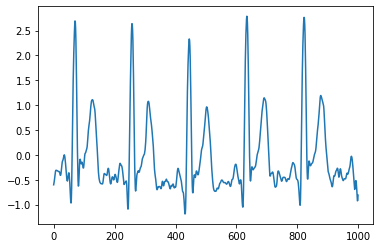

In [19]:
exs = x_test_ecg[9710,:1000]
ins = x_test_ecg[9710,:1000]
plt.plot(ins)

In [16]:
import pandas as pd
print(y_pred)
npy = np.array(y_pred)
print(np.mean(npy))
dics = {'bin':y_test_bin,'y_pred':y_pred}
histo = pd.DataFrame(dics)
histo.sort_values(by=['y_pred'],ascending=False, inplace=True)
histo.reset_index(inplace=True)
print(histo.loc[0:50])
#histo.loc[0:50].to_csv('dirtyECG.csv')
#print(histo)

[0.30830717 0.30830717 0.30830717 ... 0.30830717 0.3083072  0.3083072 ]
0.30830714
    index    bin    y_pred
0   13748  False  0.308307
1   13747  False  0.308307
2   13736  False  0.308307
3   13737  False  0.308307
4   13738  False  0.308307
5    9164  False  0.308307
6    9167  False  0.308307
7    9166  False  0.308307
8    9165  False  0.308307
9    9163  False  0.308307
10   9169  False  0.308307
11   9162  False  0.308307
12   9161  False  0.308307
13   9160  False  0.308307
14   9159  False  0.308307
15   9158  False  0.308307
16   9168  False  0.308307
17   9171   True  0.308307
18   9170  False  0.308307
19   9156  False  0.308307
20   9172   True  0.308307
21   9173   True  0.308307
22   9174   True  0.308307
23   9175   True  0.308307
24   9176   True  0.308307
25   9177   True  0.308307
26   9178   True  0.308307
27   9179   True  0.308307
28   9180   True  0.308307
29   9157  False  0.308307
30   9153  False  0.308307
31   9155  False  0.308307
32   9154  False  0.308307

In [4]:
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    r"""Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
    The Savitzky-Golay filter removes high frequency noise from data.
    It has the advantage of preserving the original shape and
    features of the signal better than other types of filtering
    approaches, such as moving averages techniques.
    Parameters
    ----------
    y : array_like, shape (N,)
        the values of the time history of the signal.
    window_size : int
        the length of the window. Must be an odd integer number.
    order : int
        the order of the polynomial used in the filtering.
        Must be less then `window_size` - 1.
    deriv: int
        the order of the derivative to compute (default = 0 means only smoothing)
    Returns
    -------
    ys : ndarray, shape (N)
        the smoothed signal (or it's n-th derivative).
    Notes
    -----
    The Savitzky-Golay is a type of low-pass filter, particularly
    suited for smoothing noisy data. The main idea behind this
    approach is to make for each point a least-square fit with a
    polynomial of high order over a odd-sized window centered at
    the point.
    Examples
    --------
    t = np.linspace(-4, 4, 500)
    y = np.exp( -t**2 ) + np.random.normal(0, 0.05, t.shape)
    ysg = savitzky_golay(y, window_size=31, order=4)
    import matplotlib.pyplot as plt
    plt.plot(t, y, label='Noisy signal')
    plt.plot(t, np.exp(-t**2), 'k', lw=1.5, label='Original signal')
    plt.plot(t, ysg, 'r', label='Filtered signal')
    plt.legend()
    plt.show()
    References
    ----------
    .. [1] A. Savitzky, M. J. E. Golay, Smoothing and Differentiation of
       Data by Simplified Least Squares Procedures. Analytical
       Chemistry, 1964, 36 (8), pp 1627-1639.
    .. [2] Numerical Recipes 3rd Edition: The Art of Scientific Computing
       W.H. Press, S.A. Teukolsky, W.T. Vetterling, B.P. Flannery
       Cambridge University Press ISBN-13: 9780521880688
    """
    import numpy as np
    from math import factorial

    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except ValueError : #, msg
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

(5000,)
(5000,)


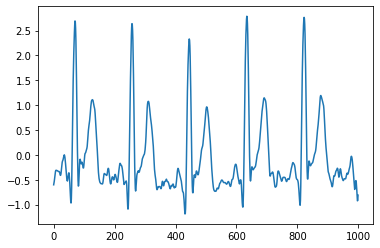

In [8]:
import matplotlib.pyplot as plt
a=x_test_ecg[6193,:].flatten()
sav = savitzky_golay(a, 25, 3, deriv=0, rate=1)
#plt.plot(a[:1000])
plt.plot(sav[:1000])
print(a.shape)
print(sav.shape)

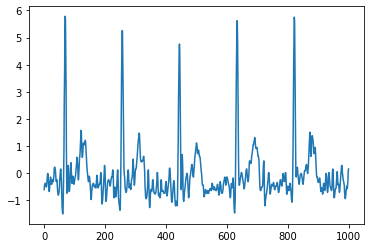

In [21]:
#Butterworth filter
from scipy.signal import butter, lfilter

def butter_bandpass(fl, fh, srate, order=5):
    nyq = 0.5 *srate
    low = fl /nyq
    high = fh / nyq
    b, a = butter(order,[low,high],btype='band')
    return b, a

def butter_bandpass_filter(data,fl,fh,srate,order=5):
    b,a=butter_bandpass(fl,fh,srate,order=order)
    y= lfilter(b,a,data)
    return y

d= butter_bandpass_filter(a,8,20,250)
plt.plot(a[:1000])
#plt.plot(d[:1000])

5000
(8196,)


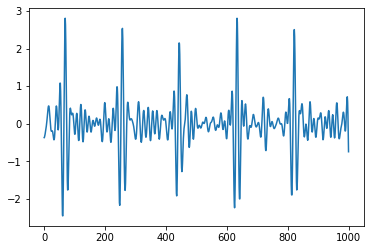

In [9]:
#Bandpass filter
import arr
import pandas as pd
import matplotlib.pyplot as plt

a=x_test_ecg[6193,:].flatten()
#plt.plot(a[:1000])
#print(a)
print(len(a))
c=np.fft.fft(a, 8196)
#print(c)
print(c.shape)
b=arr.band_pass(a,250,8,20)
plt.plot(b[:1000])

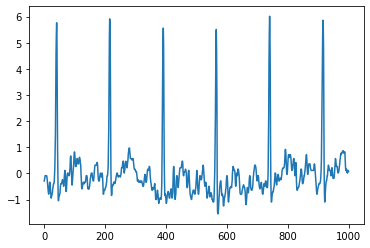

In [103]:
a=x_test_ecg[5061,:1000]
plt.plot(a)

## Model Evaluation

test set accuracy:0.64
test set auroc: 0.7577438458854677


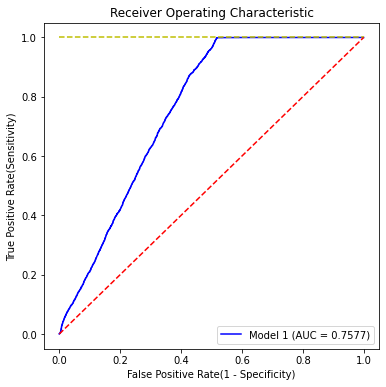

In [30]:
from sklearn.metrics import roc_curve, auc, r2_score
from numpy import interp
from keras import losses, metrics
import keras.backend as K
import matplotlib.pyplot as plt

### Classification
# Model Accuracy of test set
model_y = y_pred>=0.5
acc_val = np.mean(model_y==y_test_bin)
print('test set accuracy:{:.2f}'.format(acc_val))


# Model AUROC
false_positive_rate, true_positive_rate, threshold = roc_curve(y_test_bin, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('test set auroc:', roc_auc)

# Model R_square
#print('test set R2:', r2_score(y_test, y_pred*9))


# Adding evaluation results to file name
# classification
#os.rename(save_path, save_path+'_auc{:.4f}_acc{:.4f}'.format(roc_auc,np.mean(model_y==y_test_bin)))
os.rename(save_path,rootdir+'auc{:.4f}_acc{:.4f}'.format(roc_auc,acc_val)+mdir)
# regression
#os.rename(save_path, rootdir+'auc{:.4f}_acc{:.2f}_'.format(roc_auc,acc_val)+mdir)


# plotting roc
plt.figure(figsize=(6,6))
plt.title('Receiver Operating Characteristic')
plt.xlabel("False Positive Rate(1 - Specificity)")
plt.ylabel('True Positive Rate(Sensitivity)')

plt.plot(false_positive_rate, true_positive_rate, 'b', label='Model 1 (AUC = %0.4f)'% roc_auc)
plt.plot([0,1],[1,1],'y--')
plt.plot([0,1],[0,1],'r--')

plt.legend(loc='lower right')
plt.show()

## Model history plot
- training curve

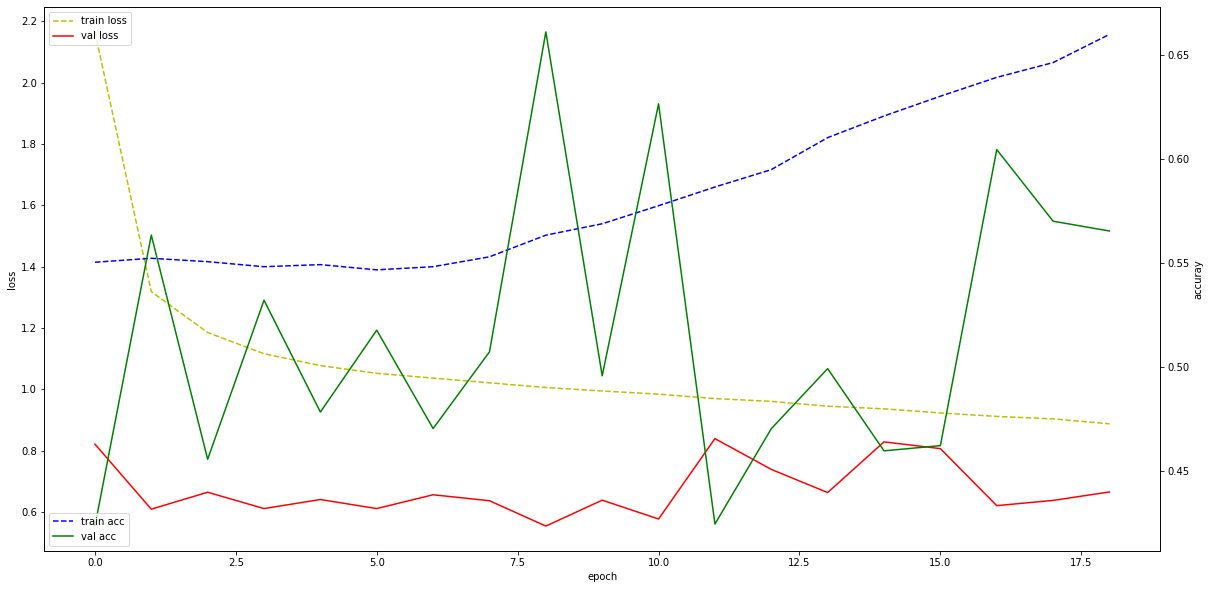

In [31]:
# model auroc 0.719짜리
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(20,10))

#x-axis는 공유하지만 y-axis는 공유x
acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', linestyle='dashed', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

#acc_ax.plot(hist.history['mean_absolute_error'], 'b', linestyle='dashed',label='train mae')
#acc_ax.plot(hist.history['val_mean_absolute_error'], 'g', label='val mae')
acc_ax.plot(hist.history['acc'], 'b', linestyle='dashed',label='train acc')
acc_ax.plot(hist.history['val_acc'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
#acc_ax.set_ylim(0.2,1.0)
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [ ]:
test_result = model.evaluate(x=x_test, y=y_test_bin, batch_size=512, verbose=1, sample_weight=None, steps=None, callbacks=None)

## Model summary

In [32]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 5000, 32)          192       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 5000, 32)          0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 5000, 32)          128       
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 2500, 32)          0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 2500, 32)          5152      
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 2500, 32)          0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 2500, 32)         

## Model ROC plot

test set auroc: 0.7829190433077462


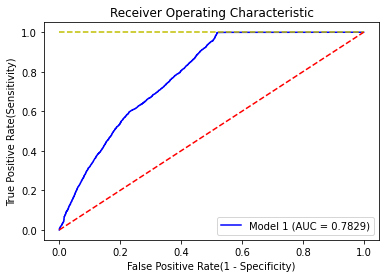

In [8]:
# Model Accuracy of test set
#print('test set accuracy:{:.2f}'.format(np.mean(y_pred>0.5==y_test_bin)))

# Model AUROC
from sklearn.metrics import roc_curve ,auc
from numpy import interp
#pipe_lr = make_pipeline(StandardScaler(), PCA(n_components=2), LogisticRegression(solver='liblinear', penalty='12', random_state=1, C=100.0))

#cv = list(StratifiedKFold(n_splits=3, shuffle=True, random_state=1).split(x_))

false_positive_rate, true_positive_rate, threshold = roc_curve(y_test_bin, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
print('test set auroc:', roc_auc)

plt.title('Receiver Operating Characteristic')
plt.xlabel("False Positive Rate(1 - Specificity)")
plt.ylabel('True Positive Rate(Sensitivity)')

plt.plot(false_positive_rate, true_positive_rate, 'b', label='Model 1 (AUC = %0.4f)'% roc_auc)
plt.plot([0,1],[1,1],'y--')
plt.plot([0,1],[0,1],'r--')

plt.legend(loc='lower right')
plt.show()